# 1.4 Unbiasing the data

In [750]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm.app  as omm_app
import simtk.openmm as omm
import simtk.unit as unit
from tqdm import tqdm
import mdtraj
from FastMBAR import *
from tqdm.notebook import tqdm_notebook

In [754]:
## read dihedral values from umbrella sampling
dists = []
num_conf = []
M=15
for window in range(M):
    dist = np.loadtxt(f"output_files/dist_win_{window+1}.csv", delimiter = ",")
    #dist = [x for x in dist if x < 1]
    dists.append(dist*10)
    num_conf.append(len(dist))
    
dists = np.concatenate(dists)
num_conf = np.array(num_conf).astype(np.float64)
N = len(dists)

## compute reduced energy matrix A
A = np.zeros((M, N))
K = 7000*0.04184
T = 298.15 * unit.kelvin
kbT = 0.001987204259*298.15
#kbT = unit.BOLTZMANN_CONSTANT_kB * 298.15 * unit.kelvin * unit.AVOGADRO_CONSTANT_NA
#kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

umbrella_centers = np.loadtxt("output_files/bias.csv", delimiter = ",")*10

for window in range(M):
    current = umbrella_centers[window]
    diff = dists - current
    A[window, :] = 0.5*K*(diff**2)/kbT
    #"0.5*k*(r-r0)^2"

## solve MBAR equations using FastMBAR
#fastmbar = FastMBAR(energy = A, num_conf = num_conf, cuda=False, verbose = True)
#print("Relative free energies: ", fastmbar.F)

In [755]:
#np.save("all_dists.npy", dists)

In [756]:
bias = A 

In [757]:
dists = []
for window in range(M):
    dist = np.loadtxt(f"output_files/dist_win_{window+1}.csv", delimiter = ",")
    #dist = [x for x in dist if x < 1]
    dists.append(dist*10)

In [758]:
RC = np.concatenate(dists)
nbins = 75
bin_centers_md = np.linspace(min(RC), max(RC), nbins)

dtrajs = []
ttrajs = []
for window in range(M):
    discrete = np.digitize(dists[window], bins=bin_centers_md)
    dtrajs.append(discrete.astype(int))
    ttrajs.append((np.ones(len(discrete))*window).astype(int))

In [759]:
np.min(bias[0].reshape(500,15))

38.97464529247925

In [760]:
bb = []
for n,b in enumerate(bias):
    bb.append(b.reshape(500, M))

In [761]:
bb[0][0]

array([ 60.70786961,  63.73350314,  67.01276731,  59.85344156,
       121.38655428,  77.31647329,  54.15763357,  68.22798325,
        69.16617216,  71.40676107,  66.29399929,  98.69135415,
        60.21888352,  83.8061669 ,  85.0774714 ])

In [766]:
from pyemma.thermo import wham
from pyemma.thermo import dtram
from pyemma.thermo import tram
from pyemma.thermo import mbar

mbar_MD = mbar(ttrajs, dtrajs, bb , maxiter=100000)
#wham_MD = wham(ttrajs, dtrajs, bias , maxiter=100000)
#dtram_MD = dtram(ttrajs, dtrajs, bias, 1, maxiter=100000)
#tram_MD = tram(ttrajs, dtrajs, bb, 1, maxiter=100000)


MBAR:   0%|                                                                                 | 0/100000 [00:00<…

Text(0.5, 0, 'Angstroms')

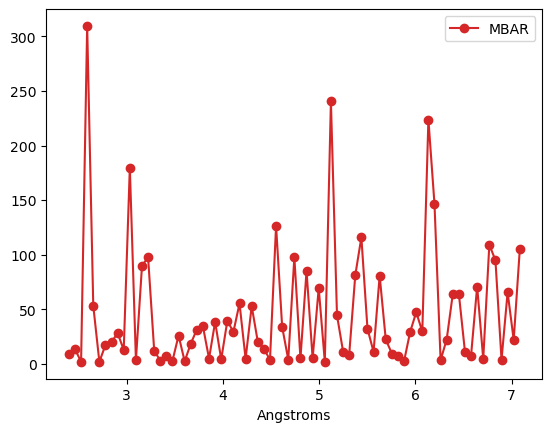

In [764]:
plt.plot(bin_centers_md, wham_MD.f, "-o", label="MBAR", c="C3")
plt.legend()
plt.xlabel("Angstroms")

In [769]:
wmd = wham_MD.free_energies - np.min(wham_MD.free_energies)
dtram = dtram_MD.free_energies - np.min(dtram_MD.free_energies)
mbar = mbar_MD.free_energies_full_state - np.min(mbar_MD.free_energies_full_state)
tram = tram_MD.free_energies_full_state - np.min(tram_MD.free_energies_full_state)

Text(0.5, 0, 'Angstroms')

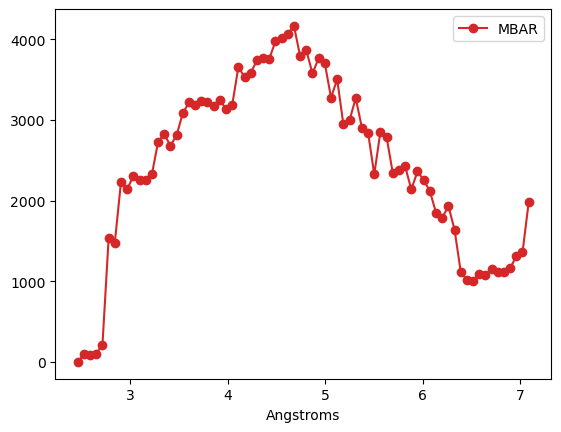

In [770]:
#plt.plot(bin_centers_md, tram[:-1], "-o", label="TRAM", c="C2")
plt.plot(bin_centers_md, mbar[:-1], "-o", label="MBAR", c="C3")
plt.legend()
plt.xlabel("Angstroms")

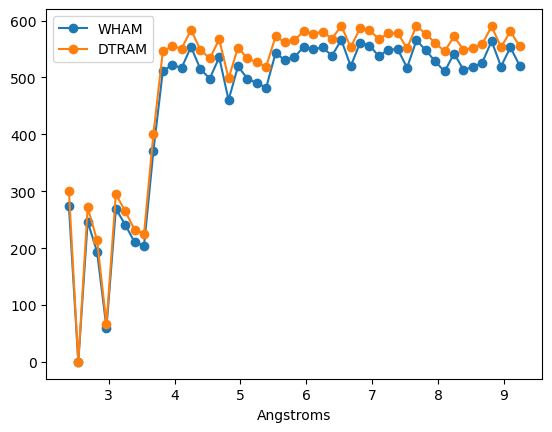

In [677]:
#plt.plot(bin_centers_md, mbar[:-1], "-o")
plt.plot(bin_centers_md[:-1], wmd, "-o", label="WHAM")
plt.plot(bin_centers_md[:-1], dtram, "-o", label="DTRAM")
#plt.plot(bin_centers_md, tram[:-1], "-o")
plt.xlabel("Angstroms")
plt.legend()

In [11]:
import os
import numpy as np
import numba
import jax
import matplotlib.pyplot as plt
from time import time


def sum_Fx(expFx_old, sim):
    denom = np.sum(expFx_old * sim)
    if denom > 0:
        denom = 1 / denom
    else:
        denom = 0
    return denom * sim


def mult_3d_1d(A, B):
    C = np.empty(shape=A.shape)
    m, n, o = A.shape
    for i in range(m):
        for j in range(n):
            for k in range(o):
                C[i, j, k] = A[i, j, k] * B[k]
    return C


numba_mult = numba.jit(numba.float64[:, :, :](numba.float64[:, :, :], numba.float64[:]), nopython=True)(mult_3d_1d)


@jax.jit
def jax_mult(A, B):
    return A * B


@jax.jit
def jax_mult_broadcast(A, B):
    return A * B


def create_bins(q, numbins):
    v_min = np.min(q)
    v_max = np.max(q)
    return np.linspace(v_min, v_max, numbins)

ModuleNotFoundError: No module named 'jax'

In [ ]:
class WHAM:
    skip = 10
    KbT = 0.001987204259 * 300  # energy unit: kcal/mol
    data = None
    k_val = None
    constr_val = None
    winsize = None
    UB = None
    Fprog = None

    def __init__(self, path):
        self.path = path
        return

    def read(self, strings=range(2, 9)):
        coor = None
        force = None
        data = None
        winsize = []
        for s in strings:
            # For string #s the constraints are in allconstr_{s-1}
            # the data is in coll_win{s}
            actcoor = np.loadtxt(os.path.join(self.path, "allconstr_{:d}.dat".format(s - 1)))
            actforce = np.loadtxt(os.path.join(self.path, "force.dat"))
            if actforce.shape != actcoor.shape:
                print("WARNING")
            winsize.append(actcoor.shape[0])
            if coor is None:
                coor = actcoor
            else:
                coor = np.append(coor, actcoor, axis=0)
            if force is None:
                force = actforce
            else:
                force = np.append(force, actforce, axis=0)
            sdata = []
            for d in range(1, winsize[-1]+1):
                u = np.loadtxt(os.path.join(self.path, "coll_win_{:d}".format(s),
                                            "data{:d}".format(d)))
                sdata.append(u[self.skip:, :])
            sdata = np.array(sdata)
            if data is None:
                data = sdata
            else:
                data = np.append(data, sdata, axis=0)
        self.data = data
        self.k_val = force
        self.constr_val = coor
        self.winsize = winsize
        return

    def calculate_UB(self):
        """
        deprecated
        :return:
        """
        numsims = self.data.shape[0]
        datlength = self.data.shape[1]

        UB = np.empty(shape=(numsims * numsims * datlength), dtype=np.float_)
        kk = 0
        for i in range(numsims):
            for j in range(datlength):
                UB[kk:kk + numsims] = np.exp(
                   -np.sum(0.5 * self.k_val[:, :] * np.square(self.constr_val[:, :] - self.data[i, j, :]),
                           axis=1) / self.KbT)
                kk += numsims
        self.UB = UB
        return

    def calculate_UB3d(self):
        numsims = self.data.shape[0]
        datlength = self.data.shape[1]

        UB = np.empty(shape=(numsims, datlength, numsims), dtype=np.float_)
        for i in range(numsims):
            for j in range(datlength):
                UB[i, j, :] = np.exp(
                   -np.sum(0.5 * self.k_val[:, :] * np.square(self.constr_val[:, :] - self.data[i, j, :]),
                           axis=1) / self.KbT)
        self.UB3d = UB
        return

    def converge(self, threshold=0.01):
        if self.UB is None:
            # self.calculate_UB()
            self.calculate_UB3d()
        numsims = self.data.shape[0]
        datlength = self.data.shape[1]
        if self.Fprog is None:
            Fprog = []
            Fx_old = np.ones(shape=numsims, dtype=np.float_)
        else:
            Fprog = self.Fprog
            Fx_old = Fprog[-1]
        change = 0.2

        while change > threshold:
            expFx_old = datlength * np.exp(Fx_old / self.KbT)
            # t1 = time()
            # a = self.UB3d * expFx_old
            # a = numba_mult(self.UB3d, expFx_old)
            a = jax_mult(self.UB3d, expFx_old)
            # t2 = time()
            sum = np.sum(a, axis=2)
            # t3 = time()
            denom = np.divide(1, sum, where=sum != 0)
            # Fxf = np.zeros(shape=self.UB3d.shape, dtype=np.float_)
            # t5 = time()
            # Fxf = self.UB3d * denom[:, :, None]
            Fxf = jax_mult_broadcast(self.UB3d, denom[:, :, None])
            # t6 = time()
            Fx = np.sum(Fxf, axis=(0, 1))
            # t7 = time()
            Fx = -self.KbT * np.log(Fx)
            Fx -= Fx[-1]
            Fx_old = Fx
            Fprog.append(Fx)
            if len(Fprog) > 1:
                change = np.max(np.abs(Fprog[-2][1:] - Fprog[-1][1:]))
            # print(t2 - t1, t3 - t2, t6 - t5, t7 - t6)
            print(change)
        self.Fprog = Fprog
        return

    def project_2d(self, cv, numbins_q=50):
        numsims = self.data.shape[0]
        datlength = self.data.shape[1]
        q1 = np.sum(self.data * cv[0], axis=2)
        # k_q1 = np.sum(self.constr_val * cv[0], axis=1)
        q2 = np.sum(self.data * cv[1], axis=2)
        # k_q2 = np.sum(self.constr_val * cv[1], axis=1)
        qep = q1 + q2
        qspace12 = create_bins(qep, numbins_q)
        qspace1 = create_bins(q1, numbins_q)
        qspace2 = create_bins(q2, numbins_q)
        Pq12 = np.zeros(shape=numbins_q, dtype=np.float_)
        Pq1 = np.zeros(shape=numbins_q, dtype=np.float_)
        Pq2 = np.zeros(shape=numbins_q, dtype=np.float_)
        Pq2d = np.zeros(shape=(numbins_q, numbins_q), dtype=np.float_)
        PepPersim = np.zeros(shape=(numsims, numbins_q), dtype=np.float_)
        for i in range(numsims):
            for j in range(datlength):
                indq = np.digitize(qep[i, j], qspace12) - 1
                indq1 = np.digitize(q1[i, j], qspace1) - 1
                indq2 = np.digitize(q2[i, j], qspace2) - 1
                Ubias = np.sum(0.5 * self.k_val[:, :] * np.square(self.constr_val[:, :] - self.data[i, j, :]), axis=1)
                denom = np.sum(datlength * np.exp((self.Fprog[-1] - Ubias) / self.KbT))
                Pq12[indq] += 1 / denom
                Pq1[indq1] += 1 / denom
                Pq2[indq2] += 1 / denom
                Pq2d[indq1, indq2] += 1 / denom
                PepPersim[i, indq] += 1 / denom
        rUep = -self.KbT * np.log(Pq12)
        valu = np.min(rUep[:int(numbins_q/2)])
        self.rUep = rUep - valu
        self.rUepPerSim = -self.KbT * np.log(PepPersim) - valu
        self.rUq2d = -self.KbT * np.log(Pq2d) - valu
        self.qspace1 = qspace1
        self.qspace2 = qspace2
        self.qspace12 = qspace12
        return

    def plot_strings(self, title):
        numsims = self.data.shape[0]
        f, a = plt.subplots()
        a.plot(self.qspace12, self.rUep, color="black")
        for i in range(numsims):
            a.plot(self.qspace12, self.rUepPerSim[i], linewidth=0.3)
        plt.title(title)
        # plt.show()
        plt.savefig()
        return
